In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('seaborn')

# 多层感知机的从零开始实现



- 感知机的不足：不能处理抑或问题（XOR）

<center><img src="../img/4_multilayer-perceptrons/XOR.png" width=60%></center>

## 多层感知机基础

- 输入层
    - 矩阵$\mathbf{X} \in \mathbb{R}^{n \times d}$表示$n$个样本的小批量，每个样本具有$d$个输入特征

- 隐藏层
    - 具有$h$个隐藏单元，$\mathbf{H} \in \mathbb{R}^{n \times h}$表示隐藏层的输出，称为**隐藏表示**（hidden representations），也被称为**隐藏层变量**（hidden-layer variable）或**隐藏变量**（hidden variable）
    - 隐藏层权重$\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$
    - 隐藏层偏置$\boldsymbol{b}^{(1)} \in \mathbb{R}^{1 \times h}$

- 输出层
    - 输出具有$q$个类别，用$\mathbf{O} \in \mathbb{R}^{n \times q}$表示
    - 输出层权重$\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$
    - 输出层偏置$\boldsymbol{b}^{(2)} \in \mathbb{R}^{1 \times q}$

- 单隐藏层的输出可以表达为

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \boldsymbol{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \boldsymbol{b}^{(2)}.
\end{aligned}
$$

- 对于任意权重值，只需合并隐藏层，便可产生具有参数$\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$和$\boldsymbol{b} = \boldsymbol{b}^{(1)} \mathbf{W}^{(2)} + \boldsymbol{b}^{(2)}$的等价单层模型

\begin{definition}\label{def:activationFun}
**激活函数**（activation function）通过计算加权和并加上偏置来确定神经元是否应该被激活，它们将输入信号转换为输出的可微运算
\end{definition}

- 激活函数通常是非线形函数，用$\sigma$表示
- 激活函数的输出（$\sigma(\cdot)$）被称为**活性值**（activations）

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \boldsymbol{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \boldsymbol{b}^{(2)}.\\
\end{aligned}
$$

\begin{theorem}\label{theo:universalApprox}
通用近似定理（Universal Approximation）：一个包含足够多隐藏层神经元的多层前馈网络，能以任意精度逼近任意预定的连续函数。
\end{theorem}


- 通过**更深**（*不是更广*）的网络可以更容易逼近许多函数

## 分类问题

|问题类型|说明|例子|
|---|---|---|
|二分类（binary）|目标只有两类|违约v.s.未违约|
|多分类（multi-class）|目标有多个类别|Fashion-MNIST|
|多标签（multi-label）|目标可以属于多个分类维度|百科文章的所属领域|

## 处理分类问题的多层感知机模型架构（architecture）

|超参|二分类问题|多分类问题|
|---|---|---|
|输入层形状|输入特征数量|同二分类|
|隐藏层|最小1，最大不限|同二分类|
|每个隐藏层的神经元|通常10到512个|同二分类|
|输出层形状|1个|每个类别1个|
|隐藏层激活函数|通常是`ReLU`，也可以是其他|同二分类|
|输出层激活函数|`Sigmoid`函数，`torch.sigmoid`|`Softmax`函数，`torch.softmax`|
|损失函数|二元交叉熵`torch.nn.BCEloss`|交叉熵`torch.nn.CrossEntropyLoss`|
|优化器|`SGD`，`Adam`|同二分类|

## 读取数据

- 仍然用Fashion-MNIST数据集

In [2]:
import sys
sys.path.append('/home/teaching/slides/deeplearning/3_linear_network')
# 将load_data_fashion_mnist函数所在路径加入系统环境变量路径中

In [5]:
from softmax_regression_scratch import load_data_fashion_mnist
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 建立模型

- Fashion-MNIST中的每个图像由$28 \times 28 = 784$个灰度像素值组成
- 所有图像共分为10个类别
- 忽略像素之间的空间结构，可以将每个图像视为具有784个输入特征和10个类的简单分类数据集

- 实现一个具有**单隐藏层**（超参）的多层感知机，包含**256个隐藏单元**（超参）
- 通常选择2的若干次幂作为层的宽度，可以在计算上更高效

### 实现ReLU激活函数

In [6]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

- 最受欢迎的激活函数是**修正线性单元**（Rectified linear unit，**ReLU**）
- ReLU提供了一种非常简单的非线性变换

给定元素$x$，ReLU函数被定义为该元素与0的最大值：

$$\operatorname{ReLU}(x) = \max(x, 0).$$

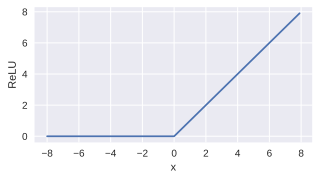

In [7]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=False)
y = torch.relu(x)
fig,ax = plt.subplots(figsize=(5, 2.5))
_ = ax.plot(x,y)
_ = ax.set(xlabel='x', ylabel='ReLU')

### 实现模型

In [8]:
def net(X):
    X = X.reshape((-1, num_inputs)) # 将输入的每个二维图像转换成长度为`num_inputs`的向量
    H = relu(X@W1 + b1)
    return (H@W2 + b2)

- $@$相当于`torch.matmul`（或者`torch.mm）
- $*$相当于`torch.mul`

- 【注意】输出层不用再加relu

### 初始化模型参数

In [9]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)  # 均值为0，标准差为0.01的正态分布
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

- ```python
torch.randn(*size)
```

    - 从标准正态分布采样（均值为0，方差为1）.


- ```python
torch.nn.Parameter(data=None, requires_grad=True)
```

    - 将`Tensor`显示地设置为模型的参数
    - `data`：输入的`Tensor`

## loss、优化器和正式训练

- 多层感知机的训练过程与softmax回归的训练过程完全相同

In [10]:
loss = nn.CrossEntropyLoss(reduction='none') # 用交叉熵作为损失函数

In [11]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)    # 随机梯度下降优化器

## 常用的优化器和损失函数

|损失函数/优化器|问题类型|`PyTorch`代码|
|---|---|---|
|SGD优化器|分类、回归|`torch.optim.SGD()`|
|Adam优化器|分类、回归|`torch.optim.Adam()`|
|二元交叉熵损失|二分类|`torch.nn.BCELoss`或`torch.nn.BCELossWithLogits`|
|交叉熵损失|多分类|`torch.nn.CrossEntropyLoss`|
|平均绝对误差(Mean Absolute Error)或L1损失|回归|`torch.nn.L1Loss`|
|均方误差（Mean Squared Error）或L2损失|回归|`torch.nn.MSELoss`|

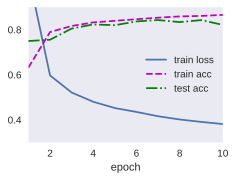

In [12]:
from softmax_regression_scratch import train_ch3   # 导入训练函数
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

## 预测

- 在检验集上应用训练好的模型

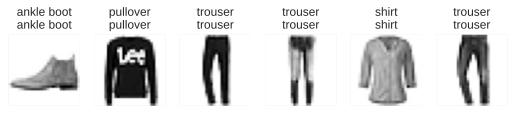

In [13]:
from softmax_regression_scratch import predict_ch3
predict_ch3(net, test_iter)